# Homework 3 - Ames Housing Dataset

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [214]:
# Importing the required library.
import pandas as pd
import numpy as np

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
from math import sqrt

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,permutation_test_score,KFold
from sklearn.metrics import mean_squared_log_error

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [215]:
#Read the given data files into data frames and filter out fraudulent and non-fraudulent dataframe

#Input file path. submission.csv will also use the same path.
file_path = 'C:/Users/ajayg/jupyter-notebook/data/house-prices-advanced-regression-techniques/'

train_house = pd.read_csv(file_path+'train.csv')
test_house = pd.read_csv(file_path+'test.csv')

print("size of Training House data = " + str(train_house.shape))
print("size of Testing House data = " + str(test_house.shape))

#Filter out data to check null values.
#Make a list of col which has null values > 50% of the data.
total_rows = train_house.shape[0]
null_rows = []
for i in train_house:
    if train_house[i].dtype == 'O':
        if train_house[i].isnull().sum() > 0:
            #print(train_house[i].value_counts())
            #print("Number of Null Values: " + str(train_house[i].isnull().sum()))
            per_null = np.round((train_house[i].isnull().sum()* 100 / total_rows), 2)
            #print("Null % in " + i + " = " + str(per_null))
            #print("\n")
            if(per_null > 50):
                null_rows.append(i)

print("List of columns in training data which has null values >50% is",null_rows)
data_house = train_house.drop(null_rows , axis = 1)
corr_list = sorted(data_house.corr(method='pearson').to_dict()['SalePrice'].items(), key=lambda x: x[1], reverse=True)

size of Training House data = (1460, 81)
size of Testing House data = (1459, 80)
List of columns in training data which has null values >50% is ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


## Part 1 - Pairwise Correlations

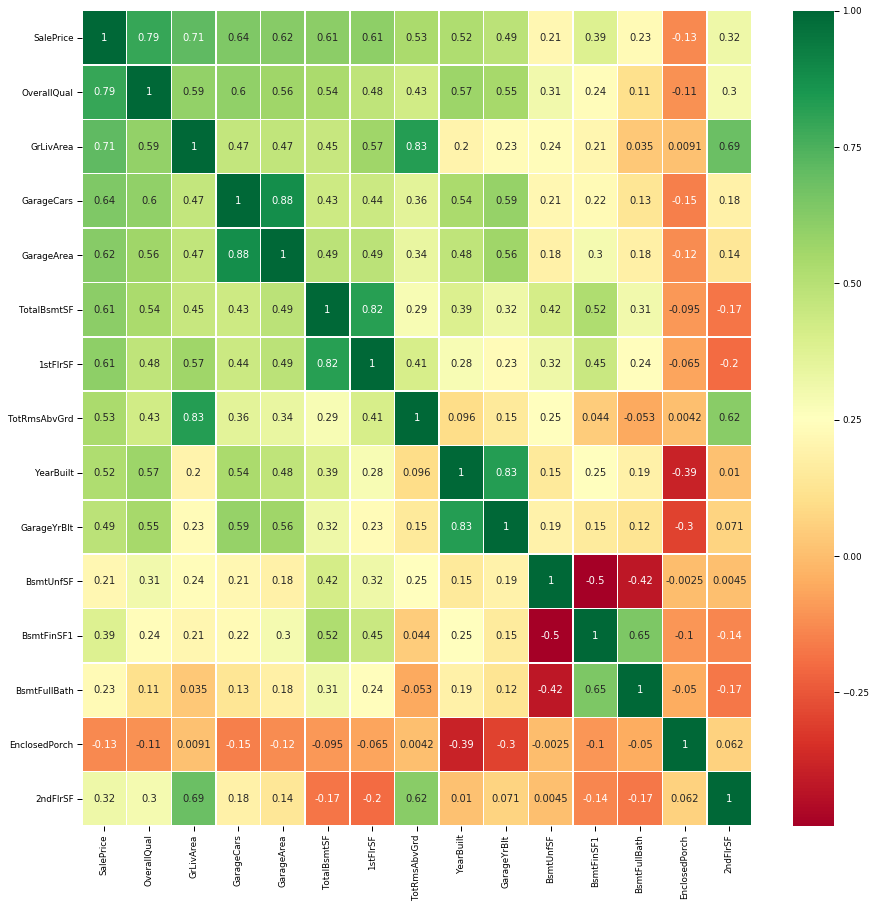

OverallQual   SalePrice       0.790982
SalePrice     OverallQual     0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
dtype: float64


BsmtUnfSF     BsmtFinSF1     -0.495251
BsmtFinSF1    BsmtUnfSF      -0.495251
BsmtFullBath  BsmtUnfSF      -0.422900
BsmtUnfSF     BsmtFullBath   -0.422900
dtype: float64


In [216]:
corr_un = train_house.corr(method='pearson').unstack()
corr_sort = corr_un.sort_values(kind="quicksort")
corr_len1 = len(corr_sort) - len(corr_sort[corr_sort.between(1,1)])

most_intersting_col = train_house[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea',
                                   'TotalBsmtSF','1stFlrSF','TotRmsAbvGrd','YearBuilt',
                                   'GarageYrBlt','BsmtUnfSF','BsmtFinSF1','BsmtFullBath',
                                   'EnclosedPorch','2ndFlrSF']].copy()
plt.subplots(figsize=(15,15))
corr = most_intersting_col.corr(method='pearson')
sns.heatmap(corr, annot=True,linewidth=0.5,cmap="RdYlGn")
plt.show()

#Print top 5 +ve correlations
print(corr_sort[corr_len1-10:corr_len1])
print('\n')
#Print lease correlated data 10.
print(corr_sort[0:4])

**Most Positive Correlation wrt SalePrice:**\
OverallQual and SalePrice = 0.79

**Most Negative Correlation wrt SalePrice:**\
KitchenAbvGr and SalePrice = -0.135907

**Most Positive Correlation**\
GarageCars and GarageArea = 0.88

GarageYrBlt and YearBuilt = 0.82

**Most Negetive Correlation:**\
BsmtUnfSF and BsmtFinSF1 = -0.49

BsmtUnfSF and BsmtFullBath = -0.42

## Part 2 - Informative Plots

In [217]:
#Update default params to plot
plt.rcParams.update(plt.rcParamsDefault)
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plot_colours = 'rbkbymc'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

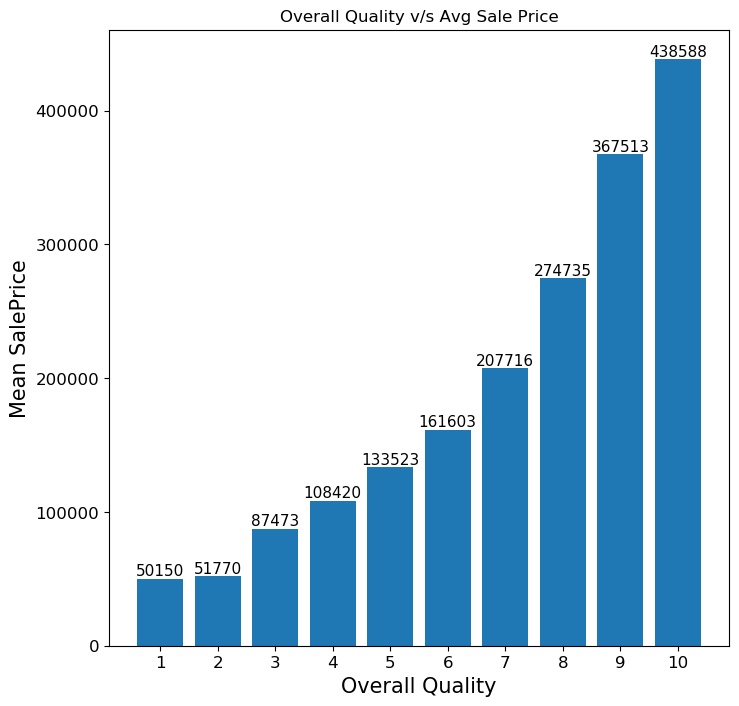

In [218]:
#OverAll Quality vs Avg Sale Price
qual_sale = data_house[['OverallQual','SalePrice']]
df=pd.DataFrame(qual_sale.groupby('OverallQual').aggregate(np.mean))
df1=pd.DataFrame({'OverallQual':df.SalePrice.index, 'MeanSale':df.SalePrice.values})


fig, ax1= plt.subplots(1,figsize=(8,8))
ax1.set_title('Overall Quality v/s Avg Sale Price',fontsize=12)
ax1.set_xlabel('Overall Quality')
ax1.set_xticks(range(0,11,1))
ax1.set_ylabel('Mean SalePrice')
rects1 = ax1.bar(df1['OverallQual'],df1['MeanSale'])

def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.999*height,
                '%d' % int(height),
                ha='center', va='bottom' , fontsize=11)

autolabel(rects1 , ax1)

plt.show()

From the above bar plot we can see that as the Overall Quality increases the average sale price for the house increases.

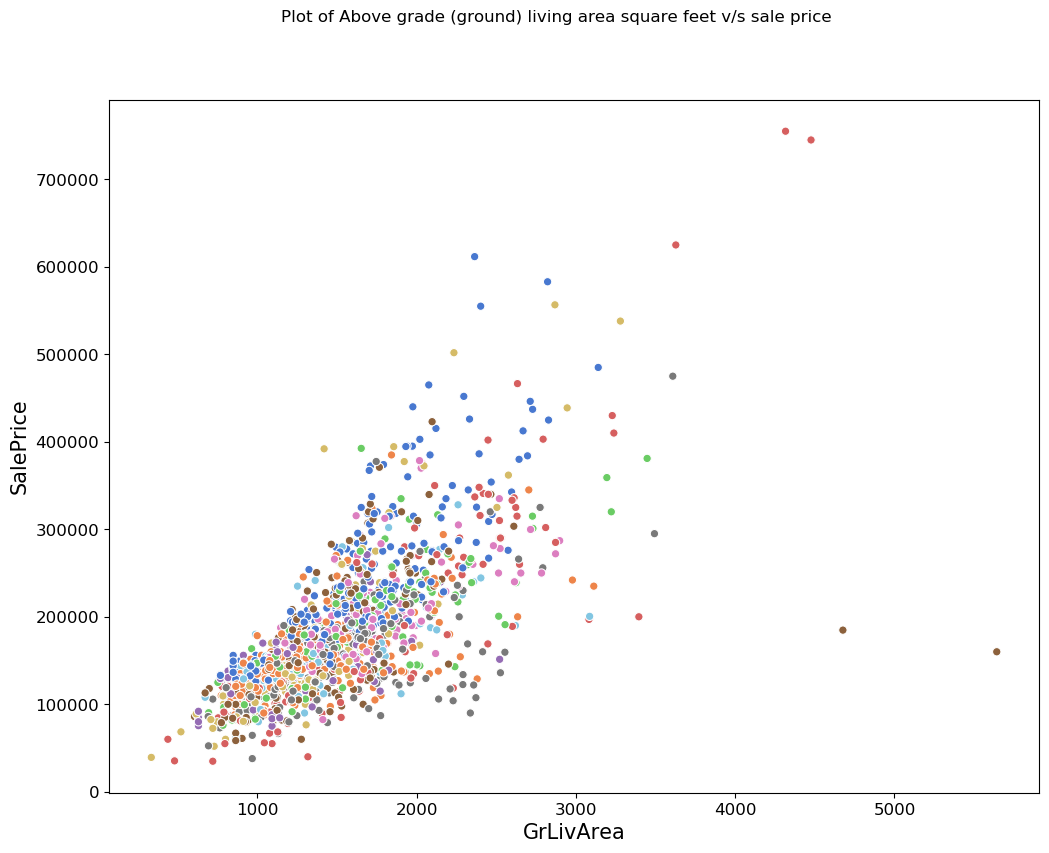

In [219]:
#GrLivArea vs sale price
plt.subplots(figsize=(12,9))
plt.suptitle('Plot of Above grade (ground) living area square feet v/s sale price ', fontsize=12)
sns.scatterplot(x="GrLivArea", y="SalePrice", data=data_house , hue="Neighborhood" , palette='muted',legend=False)
plt.show()

From the above plot we can see a relation between GrLivArea (Above Ground Living Area) and SalePrice. As GrLiveArea increase so does the sales price.
There are 4 outliers for GrLivArea > 4000 sqft

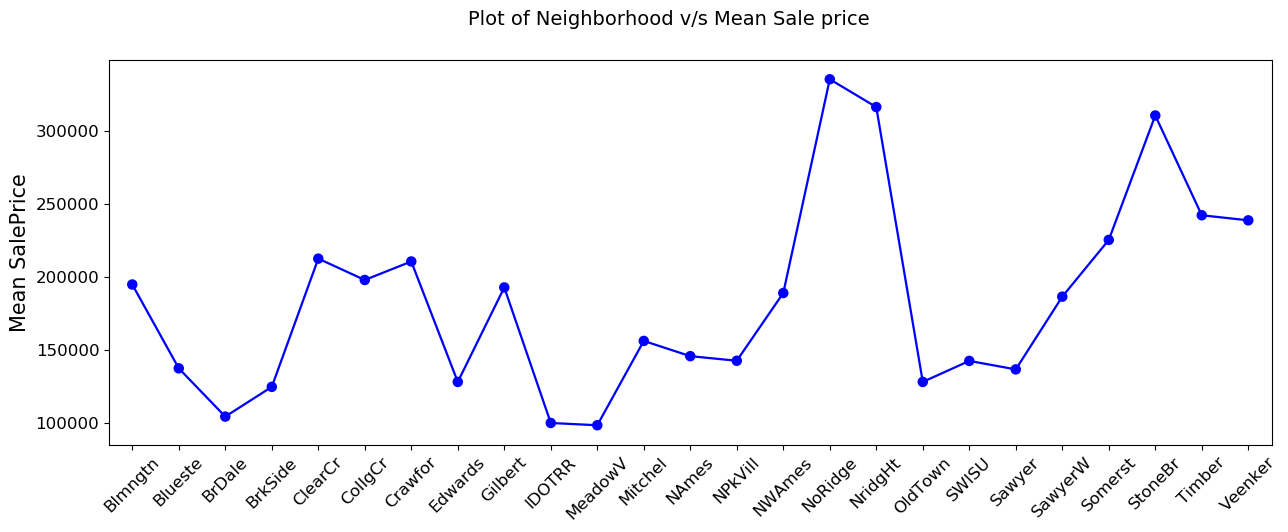

Max saleprice mean value = 335295.31707317074
Max saleprice mean value = 98576.4705882353


In [220]:
#Avg sale price v/s neighbor
unique_neighbor = np.unique(data_house['Neighborhood'].tolist()) 
mean_sale_price = data_house.groupby("Neighborhood")['SalePrice'].mean()
mean_sale_price.rename('Mean SalePrice',inplace=True)

fig, ax1 = plt.subplots(1,figsize=(15,5))
ax1.tick_params(axis='x', rotation=45)
rc = {'lines.linewidth': 0.9, 'lines.markersize': 1}                  
sns.set_context("paper", rc = rc)
sns.pointplot(y=mean_sale_price, x=unique_neighbor,color='blue',ax=ax1 , linestyle="-")
plt.setp(ax1.collections, sizes=[40])
plt.suptitle('Plot of Neighborhood v/s Mean Sale price ', fontsize=14)
plt.show()

print("Max saleprice mean value = " + str(mean_sale_price.max()))
print("Max saleprice mean value = " + str(mean_sale_price.min()))

The above line plot, plots mean sale price for every neighborhood. From the above plot we can see that,
The neighborhood Northridge has the maximum mean SalePrice = 335295 and Min value is for Meadow Village = 98576

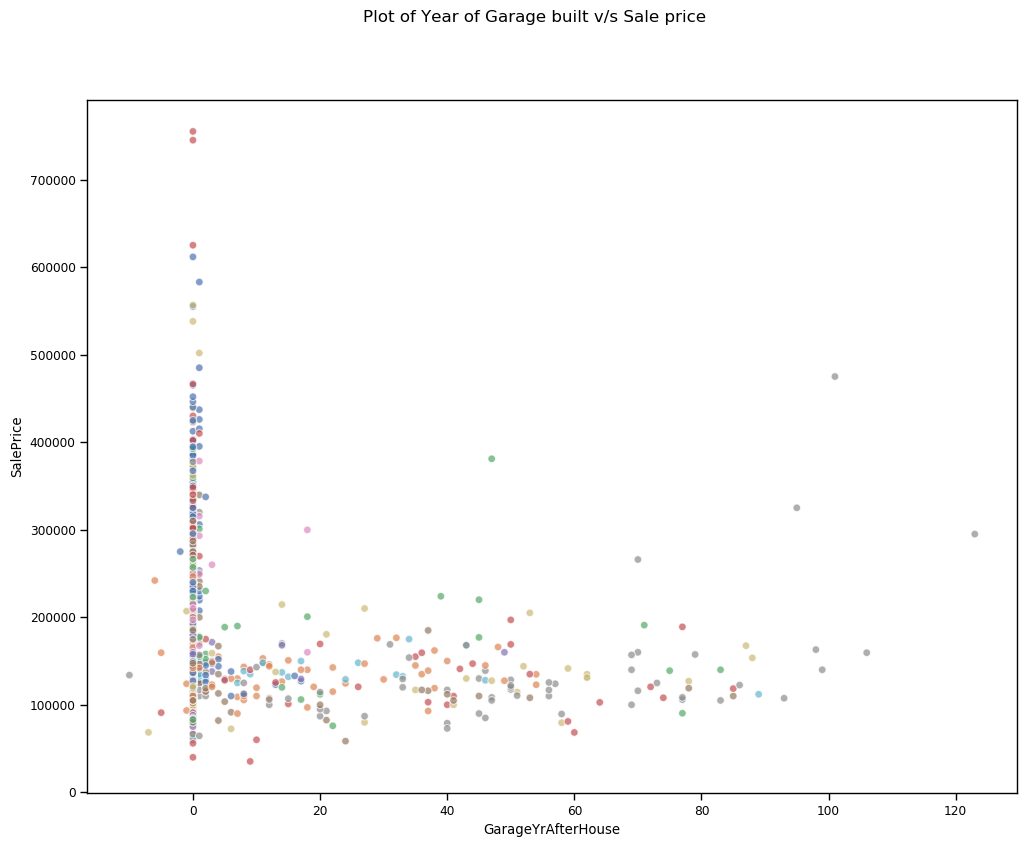

In [221]:
#GarageBuilt vs Sale Price
data_house['GarageYrAfterHouse'] = data_house['GarageYrBlt'] - data_house['YearBuilt']
plt.subplots(figsize=(12,9))
plt.suptitle('Plot of Year of Garage built v/s Sale price ', fontsize=12)
sns.scatterplot(x="GarageYrAfterHouse", y="SalePrice", data=data_house , hue="Neighborhood" , palette='deep',legend=False,\
                cmap=plt.cm.jet, s=30, linewidths=0, alpha=0.7)
plt.show()

The Garage year built is highly correlated with the year built of the house. A new column is added here which is the difference between YearBuilt (House) and GarageYrBuilt which should give the effective garage year.
From the above scatter plot we cannot conclude anything about the sale price if both garage year and YrBuilt are the same. But if they are different it the graph shows a linear correlation.

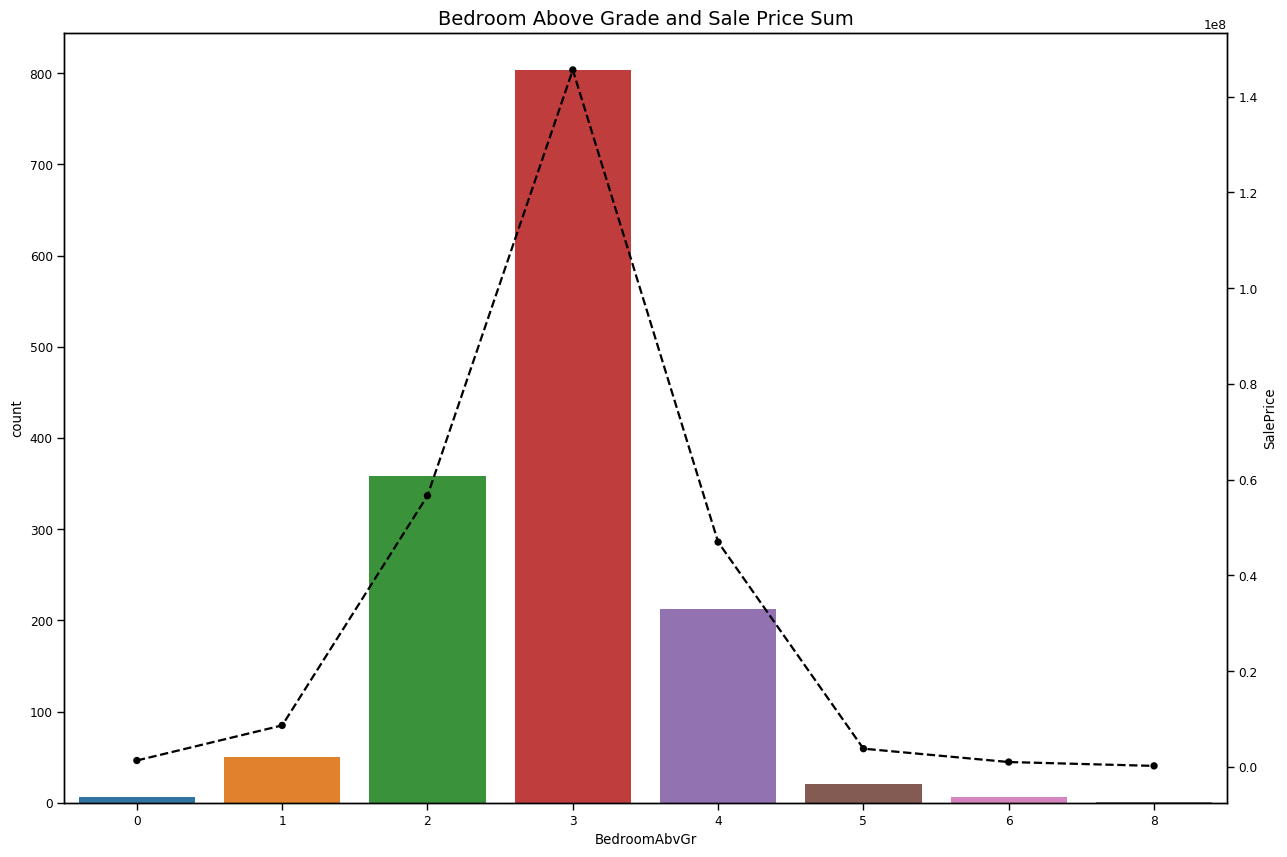

In [222]:
#No of bedrooms vs SalePrice
unique_bedroom = np.unique(data_house['BedroomAbvGr'].tolist()) 
mean_sale_price_bedroom = data_house.groupby("BedroomAbvGr")['SalePrice'].sum()
fig , ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Bedroom Above Grade and Sale Price Sum',fontsize=14)
ax2 = ax1.twinx()
_ = sns.countplot(data_house.BedroomAbvGr , ax=ax1)
_ = sns.pointplot(y=mean_sale_price_bedroom, x=unique_bedroom,color="black" , linestyles=["--"] , ax=ax2)
plt.show()

From the above plot we can see that, the housing data has a lot of houses with Bedrooms = 3.
However, the **Average Sale Price** doesn't follow the same trend.

The **Sum of Sale Prices** grouped based on number of bedrooms follows the same trend as shown in the plot.

## Part 3 - Handcrafted Scoring Function

In [223]:
#Handcrafted scoring function

#Split non-categorical data and catagorical data
int_data = data_house.select_dtypes(exclude=['object'])
obj_data = data_house.select_dtypes(include=['object'])


int_columns = int_data.columns
int_columns_list = int_columns.tolist()
obj_columns = obj_data.columns
obj_columns_list = obj_columns.tolist()

#Remove the id column.
int_columns_list.remove('Id')

#For categorical data fill NA with Not Available
for i in obj_columns_list:
    obj_data[i].fillna('Not Available',inplace=True)

#For non-categorical data fill NA with mean value
for i in int_columns_list:
    int_data[i].fillna((int_data[i].mean()), inplace=True) 

#Create a rank DF which holds the rank of all columns
rank_all_col = pd.DataFrame()

#Calculate rank of all non-categorical data
for col in int_columns_list:
    rank_all_col['Rank_'+col] = int_data[col].rank()
    
#Do one hot encoding for categotical columns to convert it into numerical data
hot_encoding = pd.get_dummies(obj_data, columns=obj_columns)
rank_all_col = pd.concat([rank_all_col, hot_encoding], axis=1, join='inner')

#Calucalate the pearson correlation of all the rank columns wrt SalePrice
corMatrix = rank_all_col.corr(method='pearson')
corSalePr = corMatrix['Rank_SalePrice'].tolist()

#To Give a Rank to a particular house.
#1. Multiply the correlation wrt SalePrice of the column with its value to get a weighted value.
#2. Sum of all the weighted values will give a rank for a particular row wrt SalePrice.
all_rank = [np.sum(r * corSalePr) for i, r in rank_all_col.iterrows()]

#Update the total_rank in the rank DF.
rank_all_col['Total_rank'] = all_rank
rank_all_col['Id'] = data_house[['Id']]

#Sort based on rank.
scoring_rank = rank_all_col.sort_values('Total_rank', ascending = False)

#rank_all_col.Total_rank.corr(data_house.SalePrice)

print("Id's for Ten Most desirable Houses")
print(scoring_rank.Id.head(10).to_string(index=False))
print('\n')
print("Id's for Ten Least desirable Houses")
print(scoring_rank.Id.tail(10).to_string(index=False))

C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Id's for Ten Most desirable Houses
  524
  799
  592
  804
 1170
 1047
 1299
  692
  390
  516


Id's for Ten Least desirable Houses
  969
  637
  977
   30
 1219
 1326
  697
 1322
 1101
  534


What is the ten most desirable houses?

**Id's for Ten Most desirable Houses**\
524, 799, 592, 804, 1170, 1047, 1299, 692, 390, 516.

What is the ten least desirable houses?

**Id's for Ten Least desirable Houses**\
969, 637, 977, 30, 1219, 1326, 697, 1322, 1101, 534.

Describe your scoring function and how well you think it worked.

The handcrafted scoring function considers all the columns (Except Id column) to calculate a rank for a house. The rank is calculated by\
**Sum (individual rank X correlation wrt SalePrice)**.

The handcrafted scoring function works pretty well. To check this, I sorted the original hosuing dataset based on 'SalePrice' and considered the top 15 Sale's Price and least 15 Sale's Prices.

**9 out of 15** Id's were present in the list of Top 15 houses (sorted by SalePrice).\
**6 out of 15** Id's were present in the list of Least 15 houses (sorted by SalePrice).

## Part 4 - Pairwise Distance Function

In [224]:
scaler = preprocessing.StandardScaler()
rank_scaled = pd.DataFrame(scaler.fit_transform(rank_all_col), columns=scoring_rank.columns)

def pair_dist_func(id1, id2):

    diff_df = abs(rank_scaled.loc[id1-1] - rank_scaled.loc[id2-1])
    #print(diff_df)
    return sum([abs(diff_df[i] * corSalePr[i]) for i in range(len(diff_df)-2)])

# min_l = [0]
# max_l = [0]
# mn = float("+inf")
# mx = float("-inf")
# for i in range(1,1460):
#     for j in range(i+1,1460):
#         val = rank_function(s, i, j)
#         if val < mn:
#             min_l[0] = ([val, i, j])
#             mn = val
#         if val > mx:
#             max_l[0] = ([val, i ,j])
#             mx=val

dist_799_804 = pair_dist_func(799, 804)
dist_1170_243 = pair_dist_func(1170,243)
print('Distance between house id 799 and house id 894 is: ',dist_799_804)
print('Distance between house id 1170 and house id 243 is: ',dist_1170_243)

Distance between house id 799 and house id 894 is:  4.928777889973085
Distance between house id 1170 and house id 243 is:  65.75862973556477


How well does the distance function work? When does it do well/badly?

The distance function is measured based on how much the 2 houses differ. As we have already calculated the rank of each columns, I have taken a difference of these standarized rank and multiplied them with the correlation wrt sale price.

Consider House Id's 799 and 804. Distance between them is 4.9 because\
Id Neighborhood BldType OverallQuality OverallCondition YearBuilt YearRemodeled  GarageYrBuilt GarageCars FullBath BedroomAbvGr\
799 NridgHt 2Story 9 5 2008 2009 2009 3 3 4\
804 NridgHt 2Story 9 5 2008 2009 2009 3 3 4

Both these houses are from same neighborhood NridgHt, both are 2Story, Has same overall quality of 9, overall condition 5, YearBuilt 2008, YearRemodeled 2009, GarageYrBuilt 2009, GarageCars 3, FullBath 3, BedroomAbvGr 4.\
They slightly differ in TotalBsmtSF. ID 799 has 1926 SF while ID 804 has 1734.\
Therefore the distance between these houses is very less.

Consider House Id's 1170 and 534. Distance between them is 65.7\
Id Neighborhood BldType	OverallQuality	OverallCondition TotalBsmtSF	GrLivArea	GarageCars	GarageArea\
1170 NoRidge	  2Story	10	            5	             1930	        3627	    3	        807\
534	 OldTown	  1.5Story	5	            4	             540	        1440	    1	        352

These houses differ in majority of features hence the distance between them is more.

The distance function performs poorly when the factors (between 2 houses) which doesnt have a good correlation to SalePrice differ a lot and factor (between 2 houses) which has good correlation with SalePrice are same. In this case the distance funtion gives less distance even though many features are different (features which doesnt contribute to SalePrice)

## Part 5 - Clustering

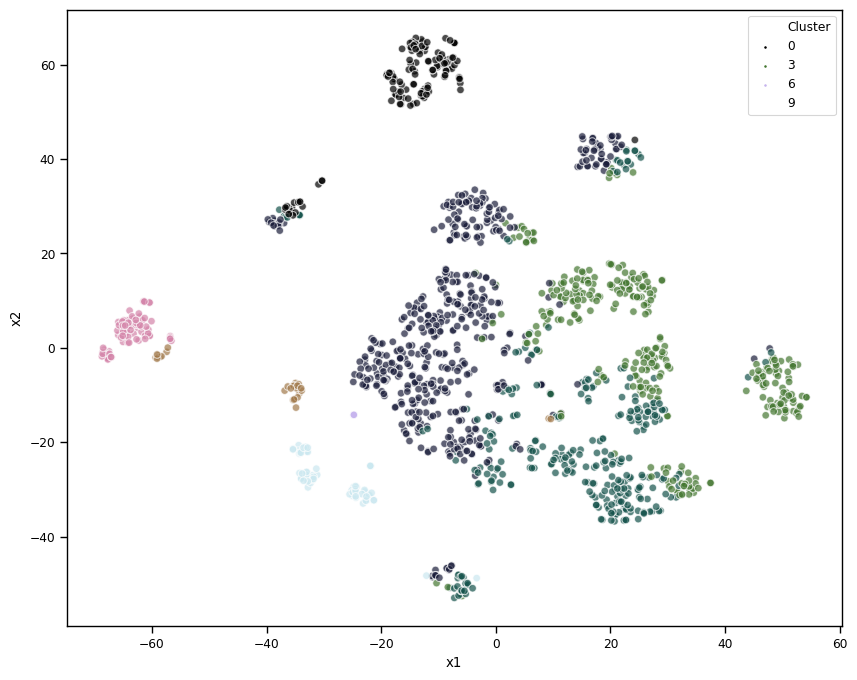

In [225]:
#From the distance rank DF calculated, consider the below col.
#Neighborhood column not considered.
cluster_data = rank_scaled[['Rank_OverallQual','Rank_OverallCond','Rank_YearBuilt',
                  'Rank_YearRemodAdd','Rank_BsmtFinSF1','Rank_BsmtFinSF2',
                  'Rank_BsmtUnfSF','Rank_TotalBsmtSF','Rank_1stFlrSF',
                  'Rank_2ndFlrSF','Rank_LowQualFinSF','Rank_GrLivArea',
                  'Rank_BsmtFullBath','Rank_BsmtHalfBath','Rank_FullBath',
                  'Rank_BedroomAbvGr','Rank_TotRmsAbvGrd','Rank_GarageYrBlt',
                  'Rank_GarageCars','Rank_GarageArea','Rank_YrSold','Rank_SalePrice',
                  'Rank_GarageYrAfterHouse','Total_rank','GarageQual_Ex',
                  'GarageQual_Fa','GarageQual_Gd','GarageQual_Not Available','GarageQual_Po',
                  'GarageQual_TA','GarageCond_Ex','GarageCond_Fa','GarageCond_Gd',
                  'GarageCond_Not Available','GarageCond_Po','GarageCond_TA','BldgType_1Fam',
                  'BldgType_2fmCon','BldgType_Duplex','BldgType_Twnhs','BldgType_TwnhsE']]

#https://www.kaggle.com/aussie84/eda-let-s-cluster-the-houses
pca = PCA(n_components=40).fit(cluster_data)
_pca = pca.fit_transform(cluster_data)
clusters = range(1,20)
kmeans = KMeans(n_clusters=9, random_state=42)
Xkmeans = kmeans.fit_predict(_pca)

#Neighborhood column appended after predict to the DF
neigh_df = data_house.Neighborhood.reset_index(drop=True)
sp_df = data_house.SalePrice.reset_index(drop=True)
_TSNE = TSNE(n_components=2).fit_transform(_pca)

clustered_neigh = pd.concat([pd.DataFrame(_TSNE),pd.DataFrame(Xkmeans),
                       pd.DataFrame(sp_df), pd.DataFrame(neigh_df)],axis=1)
clustered_neigh.columns = ['x1','x2','Cluster','SalePrice','Neighborhood']

#clustered_neigh.groupby("Neighborhood")['Cluster'].value_counts()

plt.figure(figsize=(10,8))
sns.scatterplot(x="x1", y="x2", hue="Cluster", palette="cubehelix", data=clustered_neigh, 
                cmap=plt.cm.jet, s=30, linewidths=0, alpha=0.7)
plt.show()

How well do the clusters reflect neighborhood boundaries? Write a discussion on what your clusters capture and how well they work.

Based on the distance rank df calculated few important columns were chosen to create a Kmeans cluster. The cluster is performing well. Neighborhood is concentrated to single cluster with few outliers.

Neighborhood  Cluster Count\
Blmngtn       0           16\
BrkSide       1           31\
CollgCr       3           72\
Sawyer        1           57\
Timber        3           25

Few outliers like neighborhood Crawford has been divided into both cluster 2(value count 17) and 1(12)

## Part 6 - Linear Regression

In [227]:
#Linear Regression was run by considering all the 81 columns.
#Here i have taken few columns which is very important and few columns which are not important

imp_cols = ['GrLivArea','GarageCars','GarageArea','1stFlrSF',
        'ExterQual_TA','TotalBsmtSF','Foundation_Wood','SaleType_ConLw','GarageCond_Po']

data_p=data_house[['GrLivArea','GarageCars','GarageArea','1stFlrSF',
        'ExterQual','TotalBsmtSF','Foundation','SaleType','GarageCond','SalePrice']]
int_data = data_p.select_dtypes(exclude=['object'])
obj_data = data_p.select_dtypes(include=['object'])


int_columns = int_data.columns
int_columns_list = int_columns.tolist()
obj_columns = obj_data.columns
obj_columns_list = obj_columns.tolist()

#Update NUll values with 0 from TotalBmstSF and garage Cars as replacing with mean is not proper.
replace_zero = int_data[['TotalBsmtSF','GarageCars']]
int_data.update(replace_zero.fillna(0.0))

#Replace other null values with mean.
for i in int_columns_list:
    int_data[i].fillna(int_data[i].mean() , inplace = True)

#Replace categorical null values with mode.
for o in obj_columns_list:
    obj_data[o].fillna(obj_data[o].mode()[0] , inplace = True)
    
#Do one hot encoding for all the categorical columns
one_h_enco = pd.get_dummies(obj_data, columns=obj_columns)
p_value_data = pd.concat([int_data, one_h_enco], axis=1, join='inner')

#list=[]

#Run linear regression for all columns and predict SalePrice for the entire dataset
for col in imp_cols:
    #print('Running linear Regressor Using: ',col)
    df = pd.DataFrame({col: p_value_data[col]})
    sp = p_value_data['SalePrice']

    X_train, X_test, Y_train, Y_test = train_test_split(df, sp, test_size=0.2)
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    sp_pred = lr.predict(df)
    rms_error = sqrt(mean_squared_log_error(sp,sp_pred))
    print('Log RMS Error for', col,':',rms_error)
    #list.append(tuple([col,rms_error]))

print('\n')   
#Now considering top 3 variables and training linear regressor.
print('Consider 4 important features')
df = p_value_data[['GrLivArea','GarageCars','GarageArea','1stFlrSF']]
sp = p_value_data['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(df, sp, test_size=0.2)
lr.fit(X_train, Y_train)
sp_pred = lr.predict(df)
rms_error = sqrt(mean_squared_log_error(sp,sp_pred))
print('Log RMS Error for GrLivArea, GarageCars, GarageArea, 1stFlrSF is: ',rms_error)

C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)
C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Log RMS Error for GrLivArea : 0.27520705766796355
Log RMS Error for GarageCars : 0.3230016931362338
Log RMS Error for GarageArea : 0.31722448343794174
Log RMS Error for 1stFlrSF : 0.3208259413104696
Log RMS Error for ExterQual_TA : 0.32475050654105153
Log RMS Error for TotalBsmtSF : 0.32378151107587494
Log RMS Error for Foundation_Wood : 0.4086580889722714
Log RMS Error for SaleType_ConLw : 0.4063599774103502
Log RMS Error for GarageCond_Po : 0.4078750027912256


Consider 4 important features
Log RMS Error for GrLivArea, GarageCars, GarageArea, 1stFlrSF is:  0.24607951941126768


How well/badly does it work? Which are the most important variables?

I have used few single columns and set up a linear regression model. The result is\
Log Root Mean Squared Error for GrLivArea : 0.2753474777334233\
Log Root Mean Squared Error for GarageCars : 0.32066822179034876\
Log Root Mean Squared Error for GarageArea : 0.31502148424147136\
Log Root Mean Squared Error for 1stFlrSF : 0.32064720119264495\
Log Root Mean Squared Error for ExterQual_TA : 0.3234454295556326\
Log Root Mean Squared Error for TotalBsmtSF : 0.32228524263197317\
Log Root Mean Squared Error for Foundation_Wood : 0.4078204567452345\
Log Root Mean Squared Error for SaleType_ConLw : 0.406883036169421\
Log Root Mean Squared Error for GarageCond_Po : 0.40650045809061847\

The most important variables are
1. GrLivArea
2. GarageArea
3. 1stFlrSF
4. TotalBsmtSF


Considering GrLivArea, GarageCars, GarageArea, 1stFlrSF columns we get a lower rms value = 0.24590152740940494

## Part 7 - External Dataset

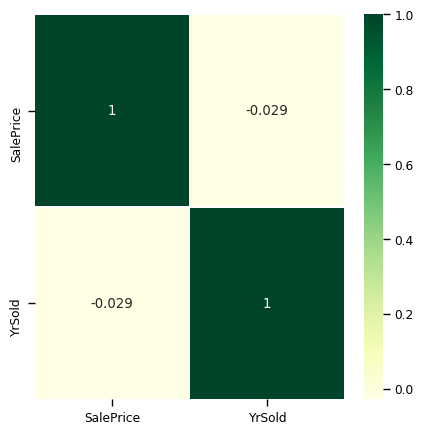

,YrSold,Mean_House_Price_Index
0,1986,67.4400
1,1987,68.9775


In [228]:
# https://fred.stlouisfed.org/series/ATNHPIUS11180Q
# Source: U.S. Federal Housing Finance Agency
# House_Price_Index

external_data = pd.read_csv(file_path+'ATNHPIUS11180Q.csv')
external_data['Year'] = [d.split('-')[0] for d in external_data.DATE]
mean_HPI = external_data.groupby('Year')['ATNHPIUS11180Q'].mean()

ext_data = pd.DataFrame()
ext_data['YrSold'] = mean_HPI.index.astype(str).astype(int)
ext_data['Mean_House_Price_Index'] = mean_HPI.values

a = pd.merge(ext_data,train_model_data,how='right',on='YrSold')

most_intersting_col = a[['SalePrice','YrSold']].copy()
plt.subplots(figsize=(5,5))
corr = most_intersting_col.corr(method='pearson')
sns.heatmap(corr, annot=True,linewidth=0.5,cmap="YlGn")
plt.show()
ext_data.head(2)

I got the data set from https://fred.stlouisfed.org/series/ATNHPIUS11180Q. The data set contains Housing Price Index form years 1986 - 2019 (Quarterly Data.)\
A house price index (HPI) measures the price changes of residential housing as a percentage change from some specific start date. So i thought this would have correlation with the SalePrice of the YearSold.

The data set had Mean Housing Price for quarter. I created a new column for Mean Housing price index per year based on the quarter data. This data was joined with our data set based on the YrSold column.

The housing index and salePrice shows a low correlation of -0.029

## Part 8 - Permutation Test

In [229]:
#Here i have taken few columns which is very important and few columns which are not important
imp_cols = ['TotalBsmtSF','GarageYrBlt','YearBuilt','YearRemodAdd',
        'FullBath','GarageCars','ExterCond_Ex','MoSold','Exterior2nd_ImStucc','LotConfig_FR3']

data_p=data_house[['TotalBsmtSF','GarageYrBlt','YearBuilt','YearRemodAdd',
        'FullBath','GarageCars','ExterCond','MoSold','Exterior2nd','LotConfig','SalePrice']]

int_data = data_p.select_dtypes(exclude=['object'])
obj_data = data_p.select_dtypes(include=['object'])

#Drop the id column
int_columns = int_data.columns
int_columns_list = int_columns.tolist()
obj_columns = obj_data.columns
obj_columns_list = obj_columns.tolist()

#Update NUll values with 0 from TotalBmstSF and garage Cars as replacing with mean is not proper.
replace_zero = int_data[['TotalBsmtSF','GarageCars']]
int_data.update(replace_zero.fillna(0.0))
int_data.update(int_data['GarageYrBlt'].fillna(int_data.YearBuilt))

#Replace other null values with mean.
for i in int_columns_list:
    int_data[i].fillna(int_data[i].mean() , inplace = True)
#Replace categorical null values with mode.   
for o in obj_columns_list:
    obj_data[o].fillna(obj_data[o].mode()[0] , inplace = True)
    
one_h_enco = pd.get_dummies(obj_data, columns=obj_columns)
p_value_data = pd.concat([int_data, one_h_enco], axis=1, join='inner')

#Calculate p-vale for every column
#list=[]
for col in imp_cols:
    df = pd.DataFrame({col: p_value_data[col]})
    sp = p_value_data['SalePrice']

    X_train, X_test, Y_train, y_test = train_test_split(df, sp, test_size=0.2)
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    score, permutation_score, p_val = permutation_test_score(lr, df, sp, cv=KFold(2), n_permutations=100,n_jobs=1,verbose=0)
    sp_pred = lr.predict(df)
    print('Log RMS Error for',col,':', sqrt(mean_squared_log_error(sp,sp_pred)) , ' and p-value is : ',p_val)
    #list.append(tuple([col,p_value]))

C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)
C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Log RMS Error for TotalBsmtSF : 0.3211443653026934  and p-value is :  0.009900990099009901
Log RMS Error for GarageYrBlt : 0.3464895325066982  and p-value is :  0.009900990099009901
Log RMS Error for YearBuilt : 0.34030002341187326  and p-value is :  0.009900990099009901
Log RMS Error for YearRemodAdd : 0.33354031697404807  and p-value is :  0.009900990099009901
Log RMS Error for FullBath : 0.3340596686892802  and p-value is :  0.009900990099009901
Log RMS Error for GarageCars : 0.3217432814505077  and p-value is :  0.009900990099009901
Log RMS Error for ExterCond_Ex : 0.40588008012191074  and p-value is :  0.801980198019802
Log RMS Error for MoSold : 0.4072113441056381  and p-value is :  0.5148514851485149
Log RMS Error for Exterior2nd_ImStucc : 0.40752222016361217  and p-value is :  0.9900990099009901
Log RMS Error for LotConfig_FR3 : 0.4075606827398563  and p-value is :  0.7227722772277227


p-values for few important columns and few Meaningless columns is shown below.

p-value for TotalBsmtSF is: 0.009900990099009901\
p-value for GarageYrBlt is:  0.009900990099009901\
p-value for YearBuilt is:  0.009900990099009901\
p-value for YearRemodAdd is:  0.009900990099009901\
p-value for FullBath is:  0.009900990099009901\
p-value for GarageCars is:  0.009900990099009901\
p-value for ExterCond_Ex is:  0.801980198019802\
p-value for MoSold is:  0.5148514851485149\
p-value for Exterior2nd_ImStucc is:  0.9900990099009901\
p-value for LotConfig_FR3 is:  0.7227722772277227

So Important columns have a low p-value. Meaningless columns like Exterior2nd has a large p-value.

## Part 9 - Final Result

In [230]:
data = train_house.copy()
data = data.drop(null_rows , axis = 1)
test_data = test_house.drop(null_rows , axis = 1)

#Concat train and test.
model_data = pd.concat([data,test_data], ignore_index = True, sort = False)

#Replace outliers with mean.
GrLivArea_mean = model_data['GrLivArea'].mean()
func = lambda x: x['GrLivArea'] > 4000 and GrLivArea_mean or x['GrLivArea']
model_data['GrLivArea'] = model_data.apply(func,axis=1).astype(float)

#Replace ordinal data Excelent with 5, Good with 4, Avg 3, Fair 2, Poor 1.
model_data.ExterQual = model_data.ExterQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data.ExterCond = model_data.ExterCond.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['BsmtQual'].fillna(0,inplace=True)
model_data.BsmtQual = model_data.BsmtQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['BsmtCond'].fillna(0,inplace=True)
model_data.BsmtCond = model_data.BsmtCond.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['BsmtExposure'].fillna(0,inplace=True)
model_data.BsmtExposure = model_data.BsmtExposure.replace({'Gd':4, 'Av':3, 'Mn':2, 'No':1})
model_data.HeatingQC = model_data.HeatingQC.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data.KitchenQual = model_data.KitchenQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['FireplaceQu'].fillna(0,inplace=True)
model_data.FireplaceQu = model_data.FireplaceQu.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['GarageQual'].fillna(0,inplace=True)
model_data.GarageQual = model_data.GarageQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
model_data['GarageCond'].fillna(0,inplace=True)
model_data.GarageCond = model_data.GarageCond.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})


#Replace NA with 0
replace_zero = model_data[['BsmtFullBath','BsmtHalfBath', 'TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','GarageArea','GarageCars']]
model_data.update(replace_zero.fillna(0.0))
model_data.update(model_data['GarageYrBlt'].fillna(model_data.YearBuilt))

#Add new columns
model_data['OverallSF'] = model_data['2ndFlrSF'] + model_data['TotalBsmtSF']

#Replace NA with mean and mode
int_col = model_data.select_dtypes(exclude=['object']).columns
obj_col = model_data.select_dtypes(include=['object']).columns
for c in int_col:
    model_data[c].fillna(model_data[c].mean() , inplace = True)
for o in obj_col:
    model_data[o].fillna(model_data[o].mode()[0] , inplace = True)

#Do label encoding for categorical values.    
le = LabelEncoder()

fie=[]
for cl in model_data.columns:
    if model_data[cl].dtype=="object":
        fie.append(cl)
for i in fie:
    model_data[i] = le.fit_transform(model_data[i].astype(str))
    

#Considering values which has high correlation with each other.
model_data.drop(["GarageArea","1stFlrSF","TotRmsAbvGrd"],axis =1, inplace = True)

#Split the data back to test and train
train_model_data = model_data.iloc[:1460,:]
test_model_data = model_data.iloc[1460:,:]

In [231]:
#Linear Regression
clf = LinearRegression()
clf.fit(train_model_data.drop(['Id','SalePrice'] , axis = 1),train_model_data['SalePrice'])
pred = clf.predict(test_model_data.drop(['Id','SalePrice'],axis=1))
o1 = pd.DataFrame({'Id': test_model_data['Id'], 'SalePrice' : pred[:]})
o1.to_csv(file_path+'submission1.csv' , index=False)

#0.13470 Kaggle score

In [198]:
#CatBoost Regressor.
reg_obj = CatBoostRegressor(
    iterations=12000,
    task_type="GPU",
    devices='0:1',
    verbose=False
)

reg_obj.fit(train_model_data.drop(['Id','SalePrice'] , axis = 1),train_model_data['SalePrice'], plot=True)

cat_model_out = reg_obj.predict(test_model_data.drop(['Id','SalePrice'],axis=1))
output_df = pd.DataFrame({'Id': test_model_data['Id'], 'SalePrice' : cat_model_out[:]})
output_df.to_csv(file_path+'submission.csv' , index=False)

#0.13121 Kaggle score

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fetaure Engineering Steps followed are\
First the train and test data was merged into a single dataset.\
From the scatter plot we saw that GrLivArea has 4 outliers, these outliers are filled with the mean value.\
For the ordinal data like ExterQual, BsmtQual etc I have replaced them with integer rank, i.e Excellent-5, Good-4, Avg-3, Fair-2, Poor-1.\
For non-categorical data missing values were updated with 0. GarageYrBlt was replaced with YearBuilt as it doesnt make sense to replace it with 0.\
A new column OverallSF is added which is = 2ndFlrSF + TotalBsmtSF.\
For categorical data the NA values are updated with mean and for non-categorical value the NA is filled with Mode.\
I am then using a label encoder for the non-categorical values.\
Columns which has high correlation between themselves has to be dropped.\
Then the test data and train data was split and given to prediction models.

1. Linear Regression - \
Linear Reg model preformed well and the time taken to fit the model is really fast.\
I obtained a kaggle score of 0.13470.
2. CatBoostRegressor - \
As CatBoostRegressor can be run on a GPU, it trains really fast. For iterations of 12000 i obtained a RMS error of 0.13121 at kaggle


## Part 10 - Kaggle Score
Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link:  https://www.kaggle.com/ajaygk

Highest Rank: 1928

Score: 0.13121

Number of entries: 7

INCLUDE IMAGE OF YOUR KAGGLE RANKING
<img src="kaggle_rank.png">